In [115]:
import os, shutil
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [116]:
from keras.utils import image_dataset_from_directory
IMG_SIZE = 32
train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=32)
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=32)
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=32)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


In [117]:
from tensorflow import keras
from keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomHeight(factor=0.2),
        layers.RandomWidth(factor=0.2),
    ]
)

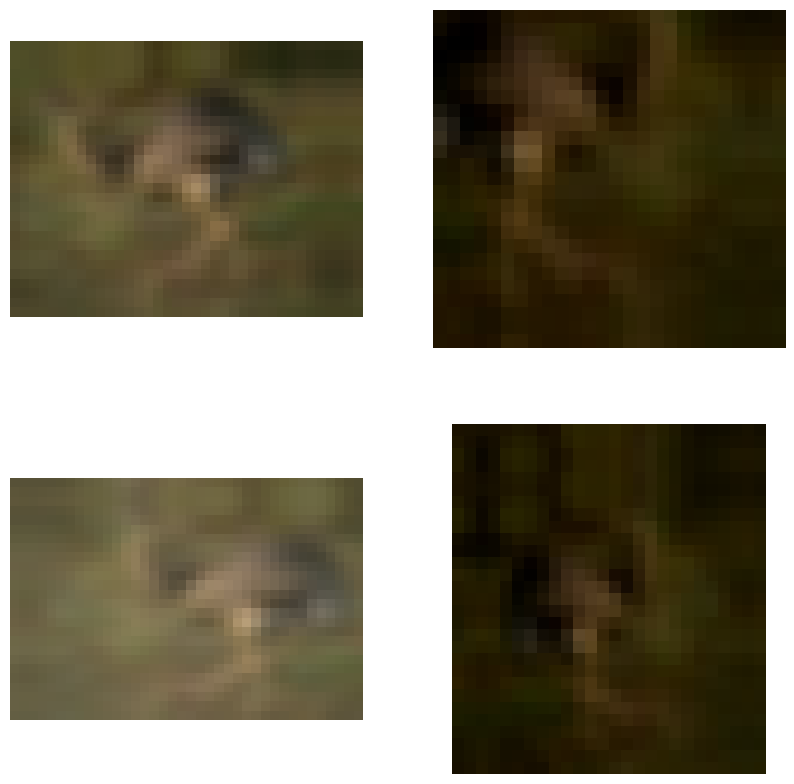

In [118]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(4):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Nesta fase do nosso código tivemos de abdicar da cama densa com L2 devido a um problema de conversão por parte do modelo de h5 para json, impedindo que o nosso modelo fosse, posteriormente, utilizado na nossa aplicação WEB.
Decidimos assim abdicar desta camada.

In [119]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
#x = layers.Dense(64, activation="relu")(x)
#x = layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
#x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['acc'])

In [120]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_60 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_24 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_58 (Dropout)        (None, 16, 16, 32)        0  

In [121]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1250/1250 [==============================] - 32s 25ms/step - loss: 1.8529 - acc: 0.3371 - val_loss: 1.8436 - val_acc: 0.3748 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 31s 25ms/step - loss: 1.5012 - acc: 0.4535 - val_loss: 1.5871 - val_acc: 0.4750 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 32s 26ms/step - loss: 1.3513 - acc: 0.5150 - val_loss: 1.2063 - val_acc: 0.5725 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 34s 27ms/step - loss: 1.2628 - acc: 0.5520 - val_loss: 1.0421 - val_acc: 0.6293 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 34s 27ms/step - loss: 1.1902 - acc: 0.5796 - val_loss: 1.1617 - val_acc: 0.5958 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 34s 27ms/step - loss: 1.1238 - acc: 0.6079 - val_loss: 1.0617 - val_acc: 0.6397 - lr: 0.0010
Epoch 7/50
1250/1250 [==============================] - 38s 30ms/step - loss: 1.0740 - acc: 0.6251 - val_l

In [122]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)
model.save('models/projeto_3_data_augmentation.h5')

313/313 [==============================] - 3s 10ms/step - loss: 0.5213 - acc: 0.8246
val_acc: 0.8245999813079834


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


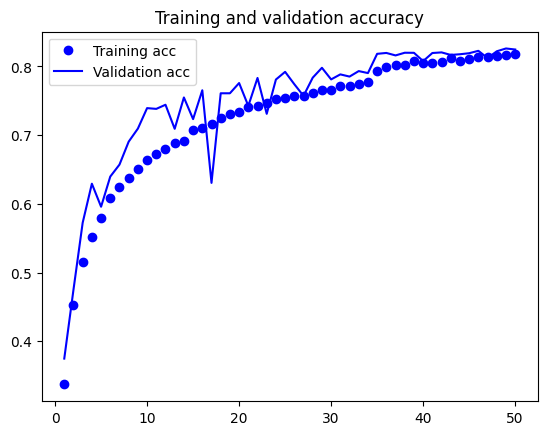

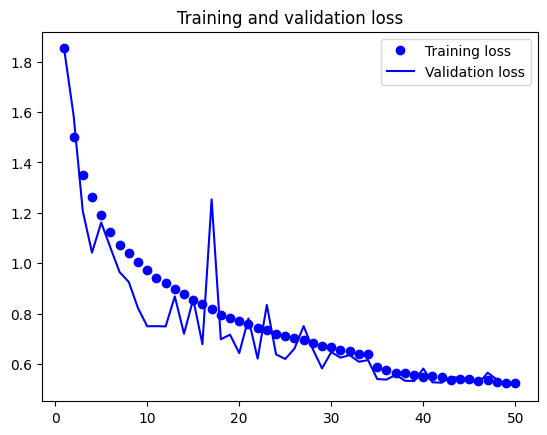

In [123]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

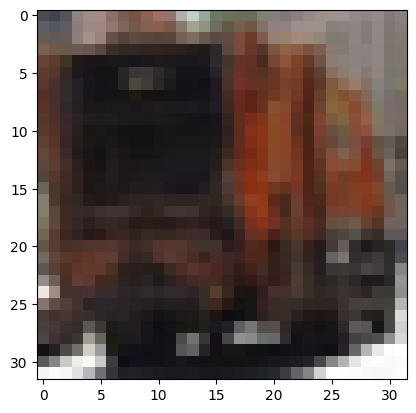

1/1 [==============================] - 0s 83ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 009_truck ---- Predicted class: Truck
Predicted probabilities: [8.9740519e-05 4.7530811e-03 1.2947510e-03 6.8952572e-03 4.6383534e-04
 1.8665007e-03 3.4659132e-04 1.5525814e-03 3.2607687e-04 9.8241156e-01]


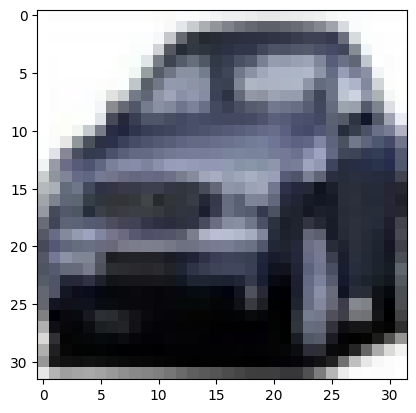

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 001_automobile ---- Predicted class: Automobile
Predicted probabilities: [4.2189987e-07 9.9979359e-01 1.3770778e-10 5.8043970e-10 2.7776564e-12
 4.7812167e-11 2.7955243e-09 2.2580572e-10 5.7383281e-06 2.0027025e-04]


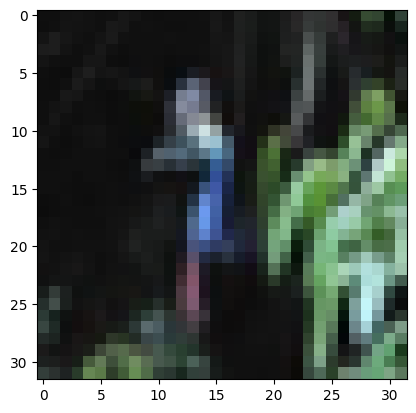

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 002_bird ---- Predicted class: Bird
Predicted probabilities: [1.8157586e-03 1.7754659e-04 8.8955551e-01 4.4353899e-02 2.8735336e-02
 4.5151752e-03 2.9842703e-02 8.6454896e-04 7.1103917e-05 6.8463494e-05]


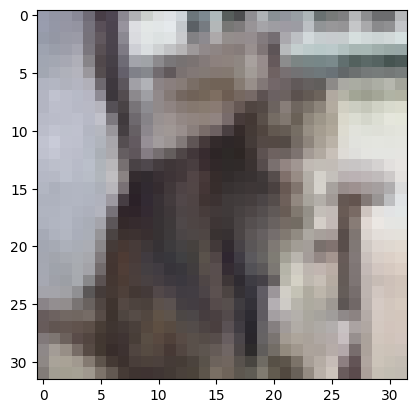

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
Actual class: 003_cat ---- Predicted class: Cat
Predicted probabilities: [2.3080604e-05 2.8178920e-06 4.9895747e-03 6.3354075e-01 1.4941202e-01
 1.7938623e-01 5.3033805e-03 2.7258566e-02 7.3934566e-06 7.6222925e-05]


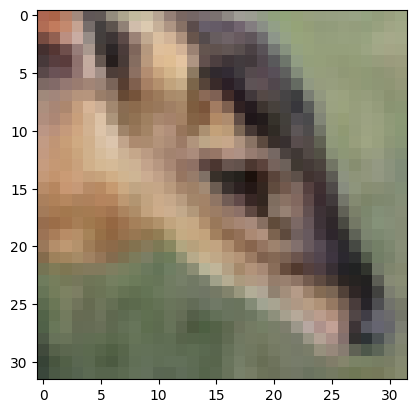

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 004_deer ---- Predicted class: Bird
Predicted probabilities: [0.02285185 0.00118216 0.5512342  0.03002954 0.15724052 0.01314951
 0.194007   0.00194746 0.0271247  0.00123311]


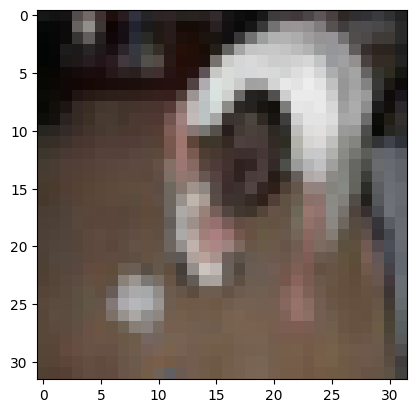

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 005_dog ---- Predicted class: Dog
Predicted probabilities: [3.8517040e-10 5.2097202e-12 2.0931770e-06 4.8428186e-04 1.6064710e-07
 9.9950850e-01 9.0189785e-09 4.9897362e-06 2.8755351e-11 3.5785608e-10]


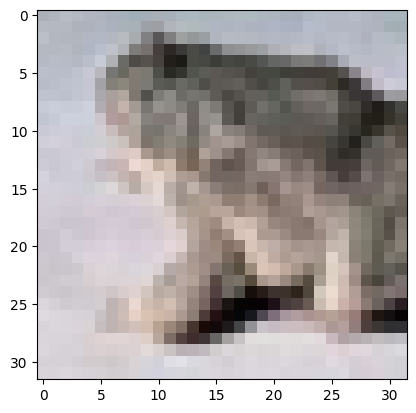

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Actual class: 006_frog ---- Predicted class: Frog
Predicted probabilities: [3.2537944e-08 2.8815638e-08 4.4139004e-05 6.6689780e-04 3.5885832e-06
 4.4198505e-06 9.9928027e-01 6.7362791e-08 9.5680992e-09 4.8045717e-07]


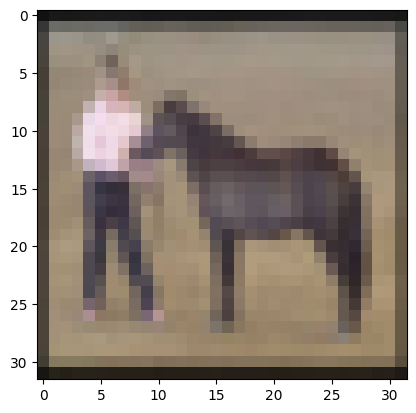

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
Actual class: 007_horse ---- Predicted class: Horse
Predicted probabilities: [6.0723585e-07 4.0788747e-10 1.3616409e-06 6.9786322e-05 8.1752399e-03
 2.6393796e-03 7.7937692e-09 9.8911309e-01 1.5388610e-09 4.1809801e-07]


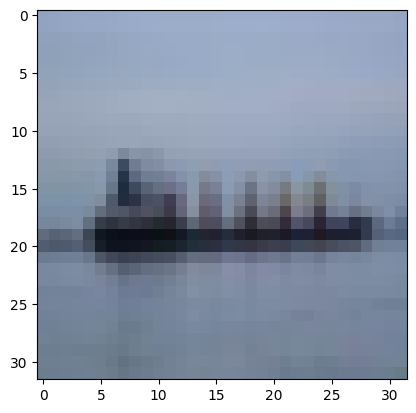

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Actual class: 008_ship ---- Predicted class: Ship
Predicted probabilities: [4.5625595e-05 4.3601394e-09 1.6117984e-09 1.9973485e-09 4.8670010e-09
 2.3332601e-11 5.9568468e-11 3.4059363e-12 9.9994385e-01 1.0495578e-05]


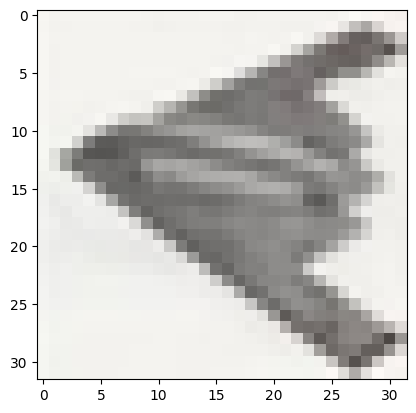

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 000_airplane ---- Predicted class: Airplane
Predicted probabilities: [9.7177839e-01 3.0627815e-04 7.7595306e-03 2.7717807e-04 3.6617967e-05
 2.1147041e-05 3.5314012e-04 7.0874700e-07 1.9433251e-02 3.3864369e-05]


In [124]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import os

# Carrega o modelo salvo
model = keras.models.load_model('models/projeto_3_data_augmentation.h5')

# Função para prever a classe de uma imagem
def predict_image_class(label):
    # Diretório das imagens de treino
    img_dir = f'../train/{label}'
    
    # Lista de arquivos de imagem no diretório
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Seleciona uma imagem aleatória da lista
    random_image = random.choice(image_files)
    img_path = os.path.join(img_dir, random_image)
    
    # Carrega e exibe a imagem
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.show()
    
    # Prepara a imagem para a predição
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realiza a predição
    predictions = model.predict(img_array)

    # Vetor de probabilidades estatísticas
    predicted_probabilities = predictions[0]
    
    # Determina a classe prevista
    predicted_class_index = np.argmax(predictions)
    
    # Vetor de predição
    predicted_vector = np.zeros_like(predictions)
    predicted_vector[0, predicted_class_index] = 1
    
    # Mapeamento de índices de classes para rótulos
    class_labels = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck"
    }
    
    # Obtém o rótulo da classe prevista
    predicted_label = class_labels[predicted_class_index]
    
    # Exibe os resultados
    print(f"Predicted vector: {predicted_vector}")
    print(f"Actual class: {label} ---- Predicted class: {predicted_label}")
    print(f"Predicted probabilities: {predicted_probabilities}")


# Lista de rótulos para prever
labels = ['009_truck', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '000_airplane']

# Realiza predições para cada rótulo na lista
for label in labels:
    predict_image_class(label)